In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn import ensemble, metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
directory = './data'
dataframes = []
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path, index_col=0)
    df = df.set_index('id')
    dataframes.append(df)

final_df = pd.concat(dataframes)
final_df = final_df.sort_index()
final_df.duplicated().sum()

0

In [3]:
final_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
1,Male,disloyal Customer,48,Business travel,Business,821,3,3,3,3,...,5,3,2,5,4,5,5,2,5.0,neutral or dissatisfied
2,Female,Loyal Customer,35,Business travel,Business,821,2,2,2,2,...,5,5,5,5,3,5,5,26,39.0,satisfied
3,Male,Loyal Customer,41,Business travel,Business,853,4,4,4,4,...,3,3,3,3,4,3,5,0,0.0,satisfied
4,Male,Loyal Customer,50,Business travel,Business,1905,2,2,2,2,...,5,5,5,5,3,5,4,0,0.0,satisfied
5,Female,Loyal Customer,49,Business travel,Business,3470,3,3,3,3,...,3,3,4,3,3,3,5,0,1.0,satisfied


In [4]:
final_df.tail()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
129876,Male,Loyal Customer,28,Personal Travel,Eco Plus,447,4,4,4,2,...,4,5,4,4,4,5,4,2,3.0,neutral or dissatisfied
129877,Male,Loyal Customer,41,Personal Travel,Eco Plus,308,3,5,3,4,...,2,5,5,5,5,4,2,0,0.0,neutral or dissatisfied
129878,Male,Loyal Customer,42,Personal Travel,Eco Plus,337,2,5,2,1,...,3,3,4,5,4,4,3,6,14.0,neutral or dissatisfied
129879,Male,Loyal Customer,50,Personal Travel,Eco Plus,337,5,4,4,1,...,3,4,5,5,3,4,3,31,22.0,satisfied
129880,Female,Loyal Customer,20,Personal Travel,Eco Plus,337,3,1,3,2,...,2,4,4,1,4,2,2,0,0.0,neutral or dissatisfied


In [5]:
null_count = final_df.loc[:, final_df.isna().sum() > 0].isna().sum()
pd.DataFrame({'null_count': null_count, 'null_percent': null_count / final_df.shape[0] * 100})

,null_count,null_percent
Arrival Delay in Minutes,393,0.302587


In [6]:
final_df['Arrival Delay in Minutes'] = final_df['Arrival Delay in Minutes'].fillna(
    value=final_df['Arrival Delay in Minutes'].mean())
final_df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [7]:
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')
final_df.columns.values

array(['gender', 'customer_type', 'age', 'type_of_travel', 'class',
       'flight_distance', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding',
       'seat_comfort', 'inflight_entertainment', 'on-board_service',
       'leg_room_service', 'baggage_handling', 'checkin_service',
       'inflight_service', 'cleanliness', 'departure_delay_in_minutes',
       'arrival_delay_in_minutes', 'satisfaction'], dtype=object)

In [8]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129880 non-null  object 
 1   customer_type                      129880 non-null  object 
 2   age                                129880 non-null  int64  
 3   type_of_travel                     129880 non-null  object 
 4   class                              129880 non-null  object 
 5   flight_distance                    129880 non-null  int64  
 6   inflight_wifi_service              129880 non-null  int64  
 7   departure/arrival_time_convenient  129880 non-null  int64  
 8   ease_of_online_booking             129880 non-null  int64  
 9   gate_location                      129880 non-null  int64  
 10  food_and_drink                     129880 non-null  int64  
 11  online_boarding                    1298

In [9]:
categorical_columns = final_df.columns[~final_df.columns.isin(
    ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes', 'satisfaction'])]
final_df[categorical_columns] = final_df[categorical_columns].astype('category')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   gender                             129880 non-null  category
 1   customer_type                      129880 non-null  category
 2   age                                129880 non-null  int64   
 3   type_of_travel                     129880 non-null  category
 4   class                              129880 non-null  category
 5   flight_distance                    129880 non-null  int64   
 6   inflight_wifi_service              129880 non-null  category
 7   departure/arrival_time_convenient  129880 non-null  category
 8   ease_of_online_booking             129880 non-null  category
 9   gate_location                      129880 non-null  category
 10  food_and_drink                     129880 non-null  category
 11  online_boarding           

In [10]:
final_df.describe()

,age,flight_distance,departure_delay_in_minutes,arrival_delay_in_minutes
count,129880.000000,129880.000000,129880.000000,129880.000000
mean,39.427957,1190.316392,14.713713,15.091129
std,15.119360,997.452477,38.071126,38.407410
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,844.000000,0.000000,0.000000
75%,51.000000,1744.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


In [11]:
final_df.describe(include=['category'])

,gender,customer_type,type_of_travel,class,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness
count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6
top,Female,Loyal Customer,Business travel,Business,2,4,3,3,4,4,4,4,4,4,4,4,4,4
freq,65899,106100,89693,62160,32320,31880,30393,35717,30563,38468,39756,36791,38703,35886,46761,36333,47323,33969


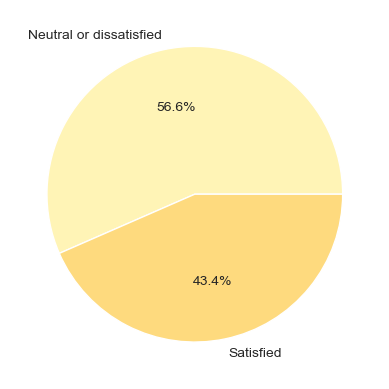

In [12]:
plt.pie(final_df.satisfaction.value_counts(), labels=["Neutral or dissatisfied", "Satisfied"],
        colors=sns.color_palette("YlOrBr"), autopct='%1.1f%%');

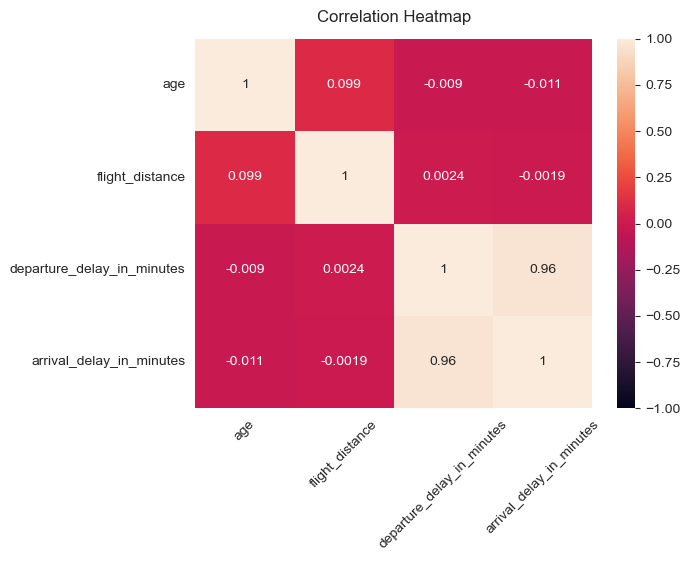

In [13]:
heatmap = sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)
plt.xticks(rotation=45);

In [14]:
vif_df = pd.DataFrame()
features = final_df.select_dtypes(include='number').columns
vif_df["feature"] = features
vif_df["VIF"] = [variance_inflation_factor(final_df[features].values, i) for i in range(len(features))]
vif_df

,feature,VIF
0,age,2.294851
1,flight_distance,2.205251
2,departure_delay_in_minutes,14.783310
3,arrival_delay_in_minutes,14.826092


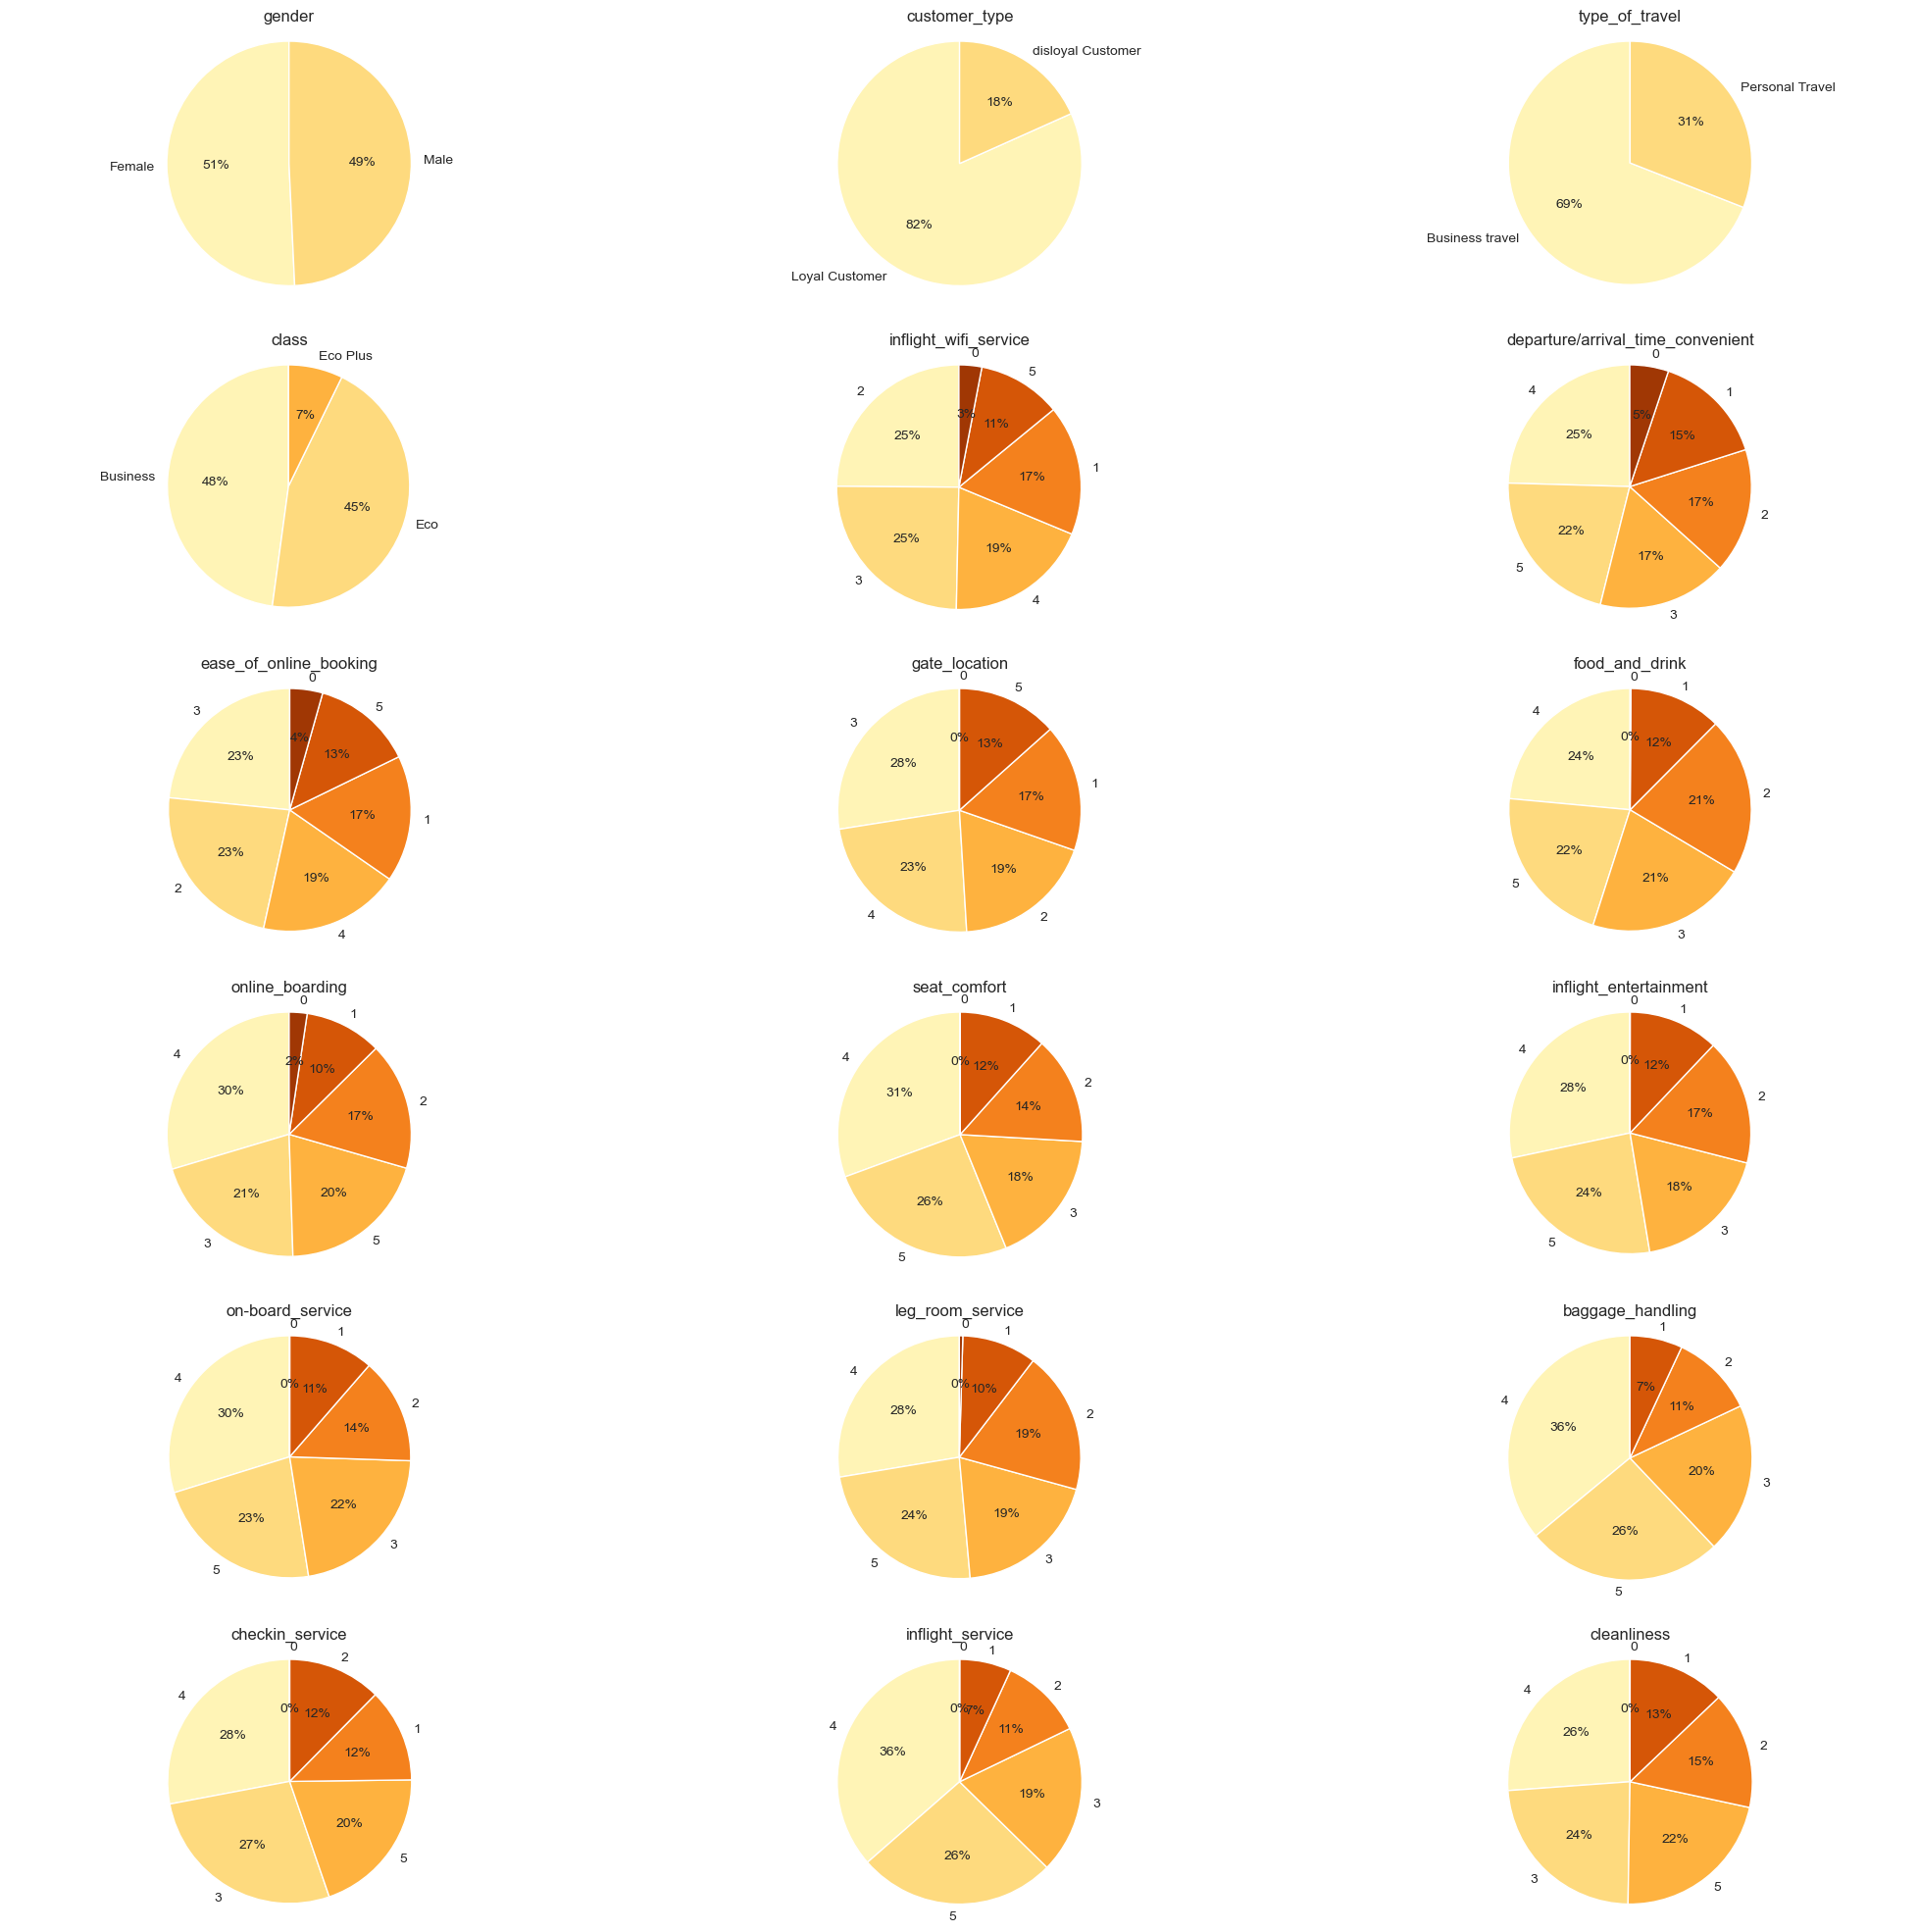

In [15]:
fig, axes = plt.subplots(6, 3, figsize=(25, 25))
for i, col in enumerate(final_df[categorical_columns]):
    column_values = final_df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i // 3, i % 3].pie(sizes, labels=labels, colors=sns.color_palette("YlOrBr"), autopct='%1.0f%%', startangle=90)
    axes[i // 3, i % 3].axis('equal')
    axes[i // 3, i % 3].set_title(col)

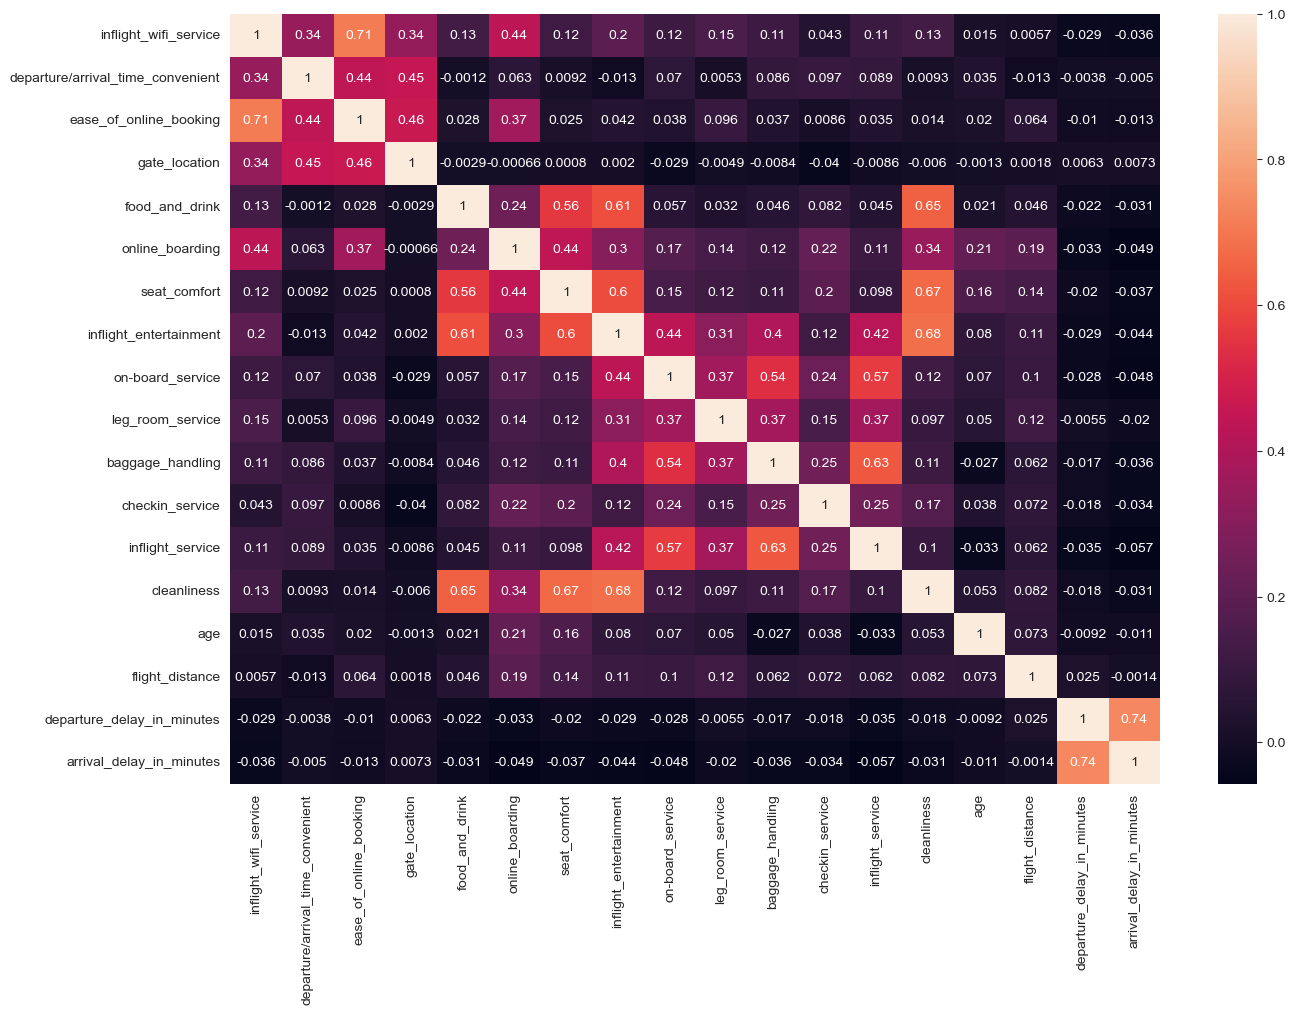

In [16]:
ordinal_df = final_df.select_dtypes('category').loc[:, 'inflight_wifi_service':].astype(int)
ordinal_continuous = ordinal_df.merge(final_df.select_dtypes(np.number), left_index=True, right_index=True)
plt.figure(figsize=(15, 10))
sns.heatmap(ordinal_continuous.corr(method='spearman'), annot=True);

In [17]:
satisfaction_mapping = {v: k for k, v in enumerate(final_df['satisfaction'].unique())}
satisfaction_mapping

{'neutral or dissatisfied': 0, 'satisfied': 1}

In [18]:
final_df['satisfaction'] = final_df['satisfaction'].map(satisfaction_mapping)
final_df['satisfaction'].head()

id
1    0
2    1
3    1
4    1
5    1
Name: satisfaction, dtype: int64

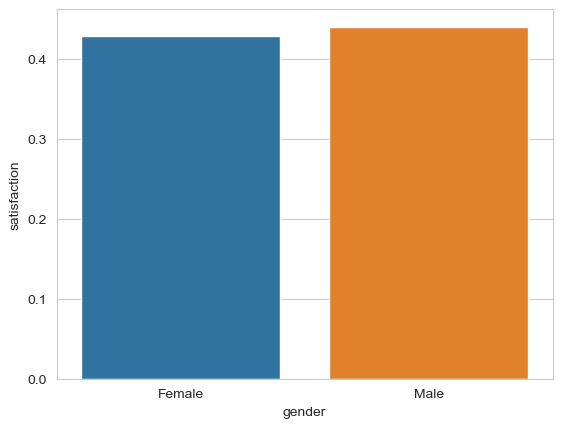

In [19]:
sns.barplot(x='gender', y='satisfaction', data=final_df, errorbar=None);

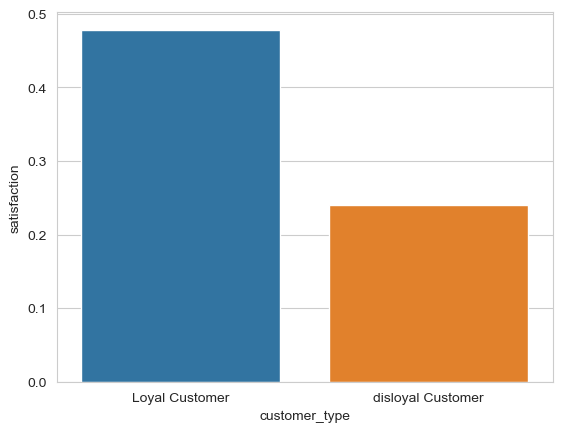

In [20]:
sns.barplot(x='customer_type', y='satisfaction', data=final_df, errorbar=None);

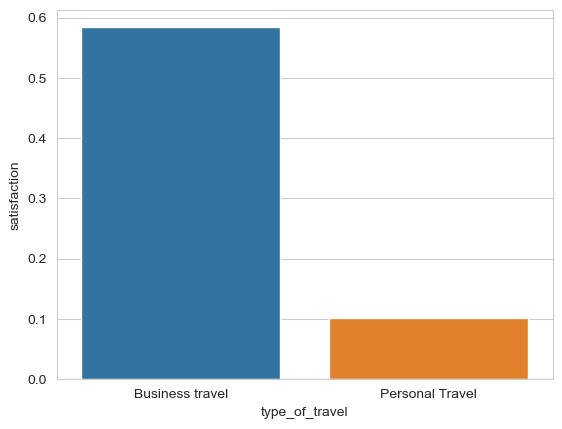

In [21]:
sns.barplot(x='type_of_travel', y='satisfaction', data=final_df, errorbar=None);

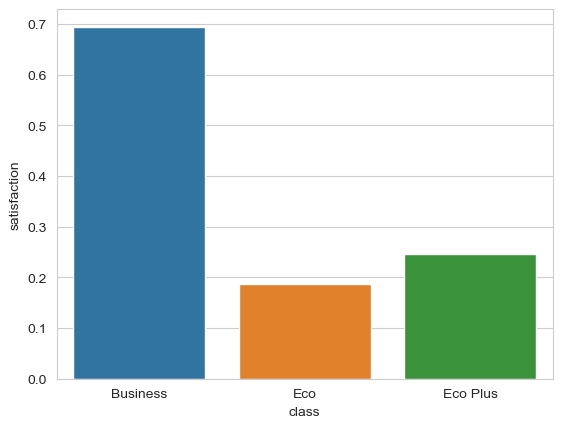

In [22]:
sns.barplot(x='class', y='satisfaction', data=final_df, errorbar=None);

In [23]:
def get_correlation_nominal(column: str, alpha=0.05, target_column: str = 'satisfaction'):
    contingency_table = pd.crosstab(final_df[column], final_df[target_column])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    return p, p <= alpha

In [24]:
nominal_columns = ['gender', 'customer_type', 'type_of_travel', 'class']
p_list, is_correlated_list = [], []
for c in nominal_columns:
    p, is_correlated = get_correlation_nominal(c)
    p_list.append(p)
    is_correlated_list.append(is_correlated)

pd.DataFrame({'p_value': p_list, 'is_correlated': is_correlated_list}, index=nominal_columns)

,p_value,is_correlated
gender,0.000053,True
customer_type,0.000000,True
type_of_travel,0.000000,True
class,0.000000,True


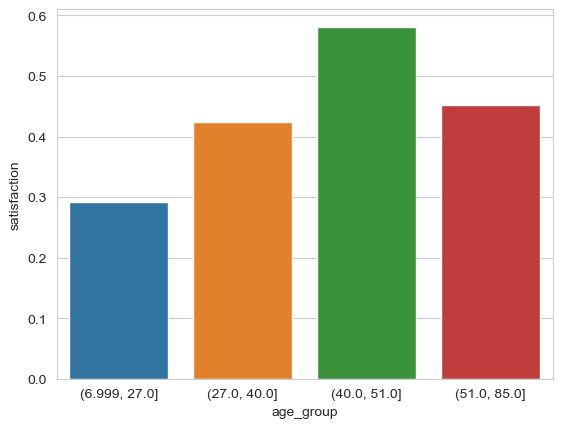

In [25]:
final_df['age_group'] = pd.qcut(final_df['age'], 4)
sns.barplot(x='age_group', y='satisfaction', data=final_df, errorbar=None);

In [26]:
final_df['age_group'] = final_df['age_group'].cat.codes + 1
final_df['age_group'].head()

id
1    3
2    2
3    3
4    3
5    3
Name: age_group, dtype: int8

In [27]:
final_df = final_df.drop(
    columns=['arrival_delay_in_minutes', 'inflight_entertainment', 'age'])
final_df.head()

,gender,customer_type,type_of_travel,class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,...,seat_comfort,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,satisfaction,age_group
id,,,,,,,,,,,,,,,,,,,,,
1,Male,disloyal Customer,Business travel,Business,821,3,3,3,3,5,...,5,3,2,5,4,5,5,2,0,3
2,Female,Loyal Customer,Business travel,Business,821,2,2,2,2,3,...,4,5,5,5,3,5,5,26,1,2
3,Male,Loyal Customer,Business travel,Business,853,4,4,4,4,5,...,5,3,3,3,4,3,5,0,1,3
4,Male,Loyal Customer,Business travel,Business,1905,2,2,2,2,4,...,5,5,5,5,3,5,4,0,1,3
5,Female,Loyal Customer,Business travel,Business,3470,3,3,3,3,4,...,4,3,4,3,3,3,5,0,1,3


In [28]:
final_df = pd.get_dummies(final_df, columns=['gender', 'customer_type', 'type_of_travel', 'class'], drop_first=True)
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')
final_df.head()

,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,on-board_service,leg_room_service,...,inflight_service,cleanliness,departure_delay_in_minutes,satisfaction,age_group,gender_male,customer_type_disloyal_customer,type_of_travel_personal_travel,class_eco,class_eco_plus
id,,,,,,,,,,,,,,,,,,,,,
1,821,3,3,3,3,5,3,5,3,2,...,5,5,2,0,3,1,1,0,0,0
2,821,2,2,2,2,3,5,4,5,5,...,5,5,26,1,2,0,0,0,0,0
3,853,4,4,4,4,5,5,5,3,3,...,3,5,0,1,3,1,0,0,0,0
4,1905,2,2,2,2,4,4,5,5,5,...,5,4,0,1,3,1,0,0,0,0
5,3470,3,3,3,3,4,5,4,3,4,...,3,5,0,1,3,0,0,0,0,0


In [29]:
X, y = final_df.drop(columns=['satisfaction']), final_df['satisfaction']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [31]:
def plot_confusion_matrix(classifier):
    predicted = classifier.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, predicted)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         confusion_matrix.flatten() / np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
    precision = confusion_matrix[1, 1] / sum(confusion_matrix[:, 1])
    recall = confusion_matrix[1, 1] / sum(confusion_matrix[1, :])
    f1_score = 2 * precision * recall / (precision + recall)
    stats_text = f"\n\nAccuracy={accuracy:.2%}\nPrecision={precision:.2%}\nRecall={recall:.2%}\nF1 Score={f1_score:.2%}"
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel(stats_text)

In [32]:
knn_pipe = Pipeline([('sc', StandardScaler()),
                     ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': range(1, 30)}
knn_gs = GridSearchCV(knn_pipe, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
knn_gs.fit(X_train, y_train)
print(f'Best accuracy: {knn_gs.best_score_:.2%}, best params: {knn_gs.best_params_}')
print(f'Test accuracy: {knn_gs.score(X_test, y_test):.2%}')

Best accuracy: 92.96%, best params: {'knn__n_neighbors': 9}
Test accuracy: 93.14%


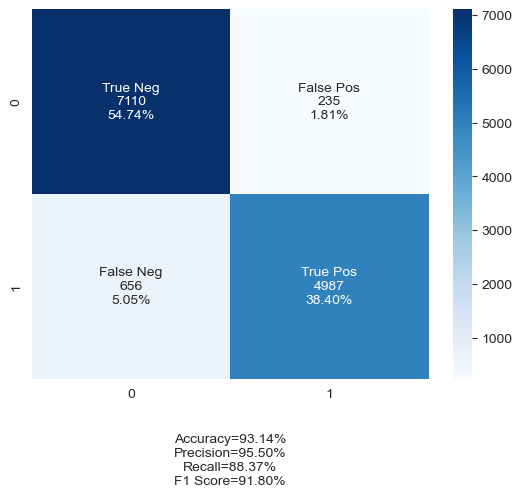

In [33]:
plot_confusion_matrix(knn_gs)

In [34]:
logistic_regression_pipe = Pipeline([('sc', StandardScaler()), ('lr', LogisticRegression())])
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]}
logistic_regression_gs = GridSearchCV(logistic_regression_pipe, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
logistic_regression_gs.fit(X_train, y_train)
print(f'Best accuracy: {logistic_regression_gs.best_score_:.2%}, best params: {logistic_regression_gs.best_params_}')
print(f'Test accuracy: {logistic_regression_gs.score(X_test, y_test):.2%}')

Best accuracy: 87.43%, best params: {'lr__C': 0.01}
Test accuracy: 87.13%


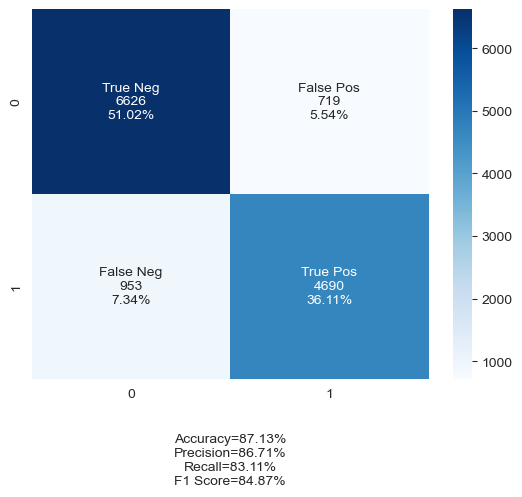

In [35]:
plot_confusion_matrix(logistic_regression_gs)

In [36]:
estimators = range(10, 201, 10)
best_accuracy = 0
best_forest = None
best_n = 0
accuracies = []
for n_estimators in estimators:
    random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators)
    random_forest.fit(X_train, y_train)
    accuracy = random_forest.score(X_test, y_test)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_forest = random_forest
        best_n = n_estimators

print(f'Test accuracy: {best_accuracy:.2%}, best number of trees: {best_n}')

Test accuracy: 96.24%, best number of trees: 160


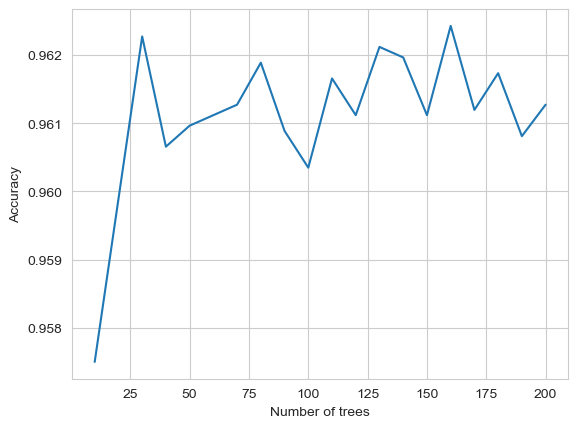

In [37]:
plt.plot(estimators, accuracies)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy');

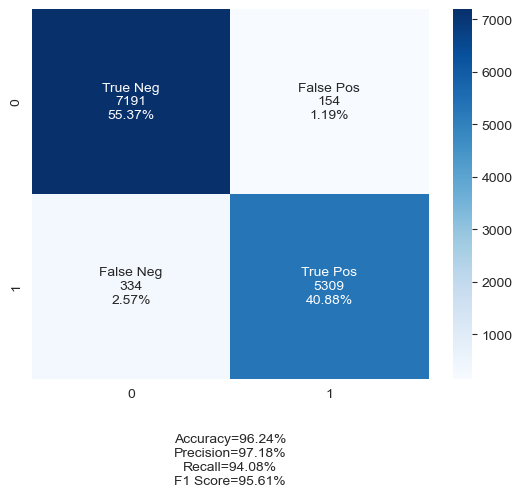

In [38]:
plot_confusion_matrix(best_forest)

In [39]:
def get_score_list(classifiers, X_data, y_data):
    predicted = {c: c.predict(X_data) for c in classifiers}
    metrics_list = [metrics.accuracy_score, metrics.precision_score, metrics.recall_score, metrics.f1_score]
    result = []
    for c in classifiers:
        result.append([metric(y_data, predicted[c]) for metric in metrics_list])
    return result


classifiers_list = [knn_gs, logistic_regression_gs, best_forest]
pd.DataFrame(get_score_list(classifiers_list, X_test, y_test), columns=['accuracy', 'precision', 'recall', 'f1_score'],
             index=['knn', 'logistic_regression', 'random_forest']).sort_values(by='accuracy', ascending=False)

,accuracy,precision,recall,f1_score
random_forest,0.962427,0.971810,0.940812,0.956060
knn,0.931398,0.954998,0.883750,0.917994
logistic_regression,0.871266,0.867073,0.831118,0.848715
